INITIALIZING DATA PROCESSING + CLEANING

 DATA PROCESSING + CLEANING COMPLETE 

INITIALIZING DATA ANALYSIS
The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results. 
 If you have not used it before, it may take a while to download as it is quite large.
['hatespeech', 'racist', 'sexist', 'neutral']


Approved
['hatespeech', 'racist', 'sexist', 'neutral']


  1%|          | 1/100 [00:00<01:32,  1.07it/s]

 rt : as a woman you shouldn't complain about cleaning up your house
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9784378409385681, 0.0648459866642952, 0.052967581897974014, 0.0029014074243605137]




  2%|▏         | 2/100 [00:01<01:15,  1.29it/s]

 rt : boy dats cold
['hatespeech', 'sexist', 'racist', 'neutral']
[0.7763931155204773, 0.13457685708999634, 0.0533047653734684, 0.00312512693926692]




  3%|▎         | 3/100 [00:02<01:35,  1.01it/s]

 rt  dawg rt : you ever fuck a bitch and she start to cry? you be confused as shit
['sexist', 'racist', 'hatespeech', 'neutral']
[0.7760063409805298, 0.1819409281015396, 0.14068084955215454, 0.00036044884473085403]




  4%|▍         | 4/100 [00:03<01:33,  1.02it/s]

 rt _g_anderson: _based she look like a tranny
['racist', 'sexist', 'hatespeech', 'neutral']
[0.7491874098777771, 0.740682065486908, 0.06922344118356705, 0.0018300164956599474]




  7%|▋         | 7/100 [00:07<01:36,  1.04s/it]

"@__brighterdays: i can not just sit up and hate on another bitch 
['hatespeech', 'sexist', 'racist', 'neutral']
[0.7977164387702942, 0.7752526998519897, 0.27690666913986206, 0.0012614167062565684]




  8%|▊         | 8/100 [00:08<01:36,  1.05s/it]

“: cause i'm tired of you big bitches coming for us skinny girls”
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8603588938713074, 0.6774135231971741, 0.23865444958209991, 0.0011993367224931717]




  9%|▉         | 9/100 [00:09<01:29,  1.01it/s]

" & you might not get ya bitch back & thats that "
['hatespeech', 'sexist', 'racist', 'neutral']
[0.6119954586029053, 0.5925929546356201, 0.1559014916419983, 0.0032551917247474194]




 10%|█         | 10/100 [00:09<01:27,  1.03it/s]

" _ :hobbies include: fighting mariam"

bitch
['sexist', 'racist', 'hatespeech', 'neutral']
[0.8869963884353638, 0.7999774217605591, 0.6022580862045288, 0.0003511799732223153]




 11%|█         | 11/100 [00:10<01:28,  1.01it/s]

" keeks is a bitch she curves everyone " lol i walked into a conversation like this
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9377551078796387, 0.7810362577438354, 0.15758806467056274, 0.00040111676207743585]




 12%|█▏        | 12/100 [00:11<01:20,  1.10it/s]

" murda gang bitch its gang land "
['hatespeech', 'racist', 'sexist', 'neutral']
[0.9859157204627991, 0.6393624544143677, 0.39917999505996704, 0.00034155967296101153]




 13%|█▎        | 13/100 [00:12<01:17,  1.12it/s]

" so hoes that smoke are losers ? " yea 
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8874860405921936, 0.5044309496879578, 0.3376745879650116, 0.005199314095079899]




 15%|█▌        | 15/100 [00:14<01:09,  1.23it/s]

" bitch get up off me "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9264681935310364, 0.8001973032951355, 0.2092466503381729, 0.003137946594506502]




 16%|█▌        | 16/100 [00:14<01:06,  1.27it/s]

" bitch nigga miss me with it "
['hatespeech', 'sexist', 'racist', 'neutral']
[0.9299280643463135, 0.8208025097846985, 0.7958342432975769, 0.0015841111307963729]




 17%|█▋        | 17/100 [00:15<01:02,  1.34it/s]

" bitch plz whatever "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.800070583820343, 0.7356282472610474, 0.09877220541238785, 0.07198610156774521]




 18%|█▊        | 18/100 [00:16<00:59,  1.37it/s]

" bitch who do you love "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.9356801509857178, 0.17884792387485504, 0.1618511974811554, 0.004994305782020092]




 19%|█▉        | 19/100 [00:16<00:59,  1.37it/s]

" bitches get cut off everyday b "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.7679325938224792, 0.1347745954990387, 0.09304272383451462, 0.0019174672197550535]




 20%|██        | 20/100 [00:17<00:58,  1.38it/s]

" black bottle & a bad bitch "
['racist', 'hatespeech', 'sexist', 'neutral']
[0.9499058127403259, 0.8598911762237549, 0.814226508140564, 0.00019474698638077825]




 21%|██        | 21/100 [00:18<00:57,  1.38it/s]

" broke bitch cant tell me nothing "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.7845157980918884, 0.38111481070518494, 0.14893272519111633, 0.001915152883157134]




 22%|██▏       | 22/100 [00:19<00:56,  1.39it/s]

" cancel that bitch like nino "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.7273811101913452, 0.5943587422370911, 0.31106287240982056, 0.004568829201161861]




 23%|██▎       | 23/100 [00:19<00:56,  1.36it/s]

" cant you see these hoes wont change "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.7546281218528748, 0.15497702360153198, 0.13803628087043762, 0.0006224268581718206]




 25%|██▌       | 25/100 [00:22<01:08,  1.09it/s]

" got ya bitch tip toeing on my hardwood floors " 😂 
['hatespeech', 'sexist', 'racist', 'neutral']
[0.7865529656410217, 0.7689049243927002, 0.09525922685861588, 0.0010135445045307279]




 26%|██▌       | 26/100 [00:22<01:04,  1.14it/s]

" her pussy lips like heaven doors " 😌
['sexist', 'racist', 'hatespeech', 'neutral']
[0.5785389542579651, 0.010179577395319939, 0.0026691623497754335, 0.001052725943736732]




 28%|██▊       | 28/100 [00:24<00:57,  1.25it/s]

" i met that pussy on ocean dr 
['sexist', 'hatespeech', 'racist', 'neutral']
[0.7210568785667419, 0.5200067162513733, 0.06350692361593246, 0.0022078361362218857]




 29%|██▉       | 29/100 [00:25<00:59,  1.20it/s]

" i need a trippy bitch who fuck on hennessy "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.867834746837616, 0.13123464584350586, 0.08478087186813354, 0.0002429704909445718]




 30%|███       | 30/100 [00:26<00:59,  1.18it/s]

" i spend my money how i want bitch its my business "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.5342047810554504, 0.4580884575843811, 0.09080468118190765, 0.005414056126028299]




 31%|███       | 31/100 [00:26<01:00,  1.15it/s]

" i txt my old bitch my new bitch pussy wetter "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.9546530246734619, 0.3712117075920105, 0.05850548669695854, 0.0009718115325085819]




 32%|███▏      | 32/100 [00:28<01:04,  1.06it/s]

" i'd say im back to the old me but my old bitches would get excited " 😌
['sexist', 'hatespeech', 'racist', 'neutral']
[0.6559137105941772, 0.08254069834947586, 0.020464636385440826, 0.010098380036652088]




 33%|███▎      | 33/100 [00:29<01:03,  1.06it/s]

" if you aint bout that murder game pussy nigga shut up "
['hatespeech', 'sexist', 'racist', 'neutral']
[0.9364069700241089, 0.9145834445953369, 0.7794150710105896, 0.0006000306457281113]




 34%|███▍      | 34/100 [00:29<01:01,  1.08it/s]

" if you're toes ain't done you pussy stinks "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8639248013496399, 0.7078208923339844, 0.21395140886306763, 0.0017247844953089952]




 35%|███▌      | 35/100 [00:30<00:59,  1.10it/s]

" im done with bitter bitches its a wrap for that 
['hatespeech', 'sexist', 'racist', 'neutral']
[0.6961096525192261, 0.18384265899658203, 0.02005334198474884, 0.0025728128384798765]




 36%|███▌      | 36/100 [00:31<00:53,  1.20it/s]

" is that ya bitch "
['hatespeech', 'sexist', 'racist', 'neutral']
[0.9310804605484009, 0.8264582753181458, 0.35621359944343567, 0.0013349700020626187]




 37%|███▋      | 37/100 [00:32<00:52,  1.20it/s]

" it aint nothing to cut a bitch off "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8152914047241211, 0.4272534251213074, 0.1450095772743225, 0.0005389478174038231]




 38%|███▊      | 38/100 [00:33<00:53,  1.15it/s]

" jus meet son now he ya mane ass bitches " shots
['hatespeech', 'sexist', 'racist', 'neutral']
[0.9233523011207581, 0.916297435760498, 0.5832903385162354, 0.00045430564205162227]




 39%|███▉      | 39/100 [00:34<00:52,  1.16it/s]

" lames crying over hoes thats tears of a clown "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9681472778320312, 0.43790268898010254, 0.1366191953420639, 0.001464027096517384]




 40%|████      | 40/100 [00:35<00:53,  1.13it/s]

" like snoop said in 94 we dont love these hoes "
['hatespeech', 'sexist', 'racist', 'neutral']
[0.9239574074745178, 0.7081936597824097, 0.27145346999168396, 0.0009417111286893487]




 41%|████      | 41/100 [00:35<00:52,  1.13it/s]

" momma said no pussy cats inside my doghouse "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.5696519017219543, 0.09671811014413834, 0.035850875079631805, 0.003261297708377242]




 42%|████▏     | 42/100 [00:36<00:53,  1.09it/s]

" most hated but the hoes favorite " 2mw sevenone  
['hatespeech', 'sexist', 'racist', 'neutral']
[0.8506367802619934, 0.6715319156646729, 0.13191820681095123, 0.0066788410767912865]




 43%|████▎     | 43/100 [00:37<00:49,  1.16it/s]

" nice girls bad, make me get naughty
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8979789614677429, 0.40676063299179077, 0.04780818521976471, 0.0004122688842471689]




 44%|████▍     | 44/100 [00:38<00:48,  1.15it/s]

" pimps up pimps up hoes down " future voice
['sexist', 'racist', 'hatespeech', 'neutral']
[0.7636568546295166, 0.17312894761562347, 0.06416790932416916, 0.00017627060879021883]




 45%|████▌     | 45/100 [00:39<00:46,  1.18it/s]

" post a picture of that pussy get 200 likes "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.9398708939552307, 0.13349932432174683, 0.08003304153680801, 0.008053549565374851]




 46%|████▌     | 46/100 [00:40<00:46,  1.16it/s]

" pussy is a powerful drug " 😅 happyhumpday 
['sexist', 'racist', 'hatespeech', 'neutral']
[0.7640539407730103, 0.016905048862099648, 0.0035116944927722216, 0.00168682134244591]




 47%|████▋     | 47/100 [00:41<00:44,  1.18it/s]

" quick piece of pussy call it a drive by "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9103636145591736, 0.7203205823898315, 0.10339625924825668, 0.004029474221169949]




 48%|████▊     | 48/100 [00:41<00:45,  1.15it/s]

" running round here like some brand new pussy thats bout to get fucked "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.8676164150238037, 0.37192392349243164, 0.04541696608066559, 0.00020558087271638215]




 49%|████▉     | 49/100 [00:42<00:44,  1.14it/s]

" these bitches even worst they'll send them guys for you "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9282125234603882, 0.6376889944076538, 0.44370096921920776, 0.0005807753186672926]




 50%|█████     | 50/100 [00:43<00:45,  1.10it/s]

" these hoes like niggas that spend money not talk bout it "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8618833422660828, 0.6188459992408752, 0.5126328468322754, 0.0010000295005738735]




 51%|█████     | 51/100 [00:44<00:43,  1.12it/s]

" we dont trust these niggas all these bitches "
['sexist', 'racist', 'hatespeech', 'neutral']
[0.6575868725776672, 0.6072430610656738, 0.4954972565174103, 0.0007051317952573299]




 52%|█████▏    | 52/100 [00:45<00:46,  1.04it/s]

" yall niggas b cuffing hoes cause yall aint never have bitches "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9139419794082642, 0.9069324135780334, 0.8630694150924683, 0.0006439485005103052]




 53%|█████▎    | 53/100 [00:47<00:49,  1.05s/it]

" you dodge a bullet " 😅 “: "all da bitches i cut off pregnant or bound to be 
['sexist', 'hatespeech', 'racist', 'neutral']
[0.6582745909690857, 0.62383633852005, 0.07928702235221863, 0.0008022831752896309]




 54%|█████▍    | 54/100 [00:47<00:45,  1.01it/s]

" young pill chamberlain these bitches love my music "
['sexist', 'hatespeech', 'racist', 'neutral']
[0.6846333146095276, 0.07283559441566467, 0.05020175501704216, 0.0017694823909550905]




 58%|█████▊    | 58/100 [00:54<00:55,  1.31s/it]

"& he's gone always be a hoe"
['hatespeech', 'sexist', 'racist', 'neutral']
[0.8970876932144165, 0.8818155527114868, 0.5362358093261719, 0.002163473516702652]




 61%|██████    | 61/100 [00:56<00:40,  1.03s/it]

": i probably wouldn’t mind school as much if we didn’t have to deal with bitch ass teachers"
['hatespeech', 'sexist', 'racist', 'neutral']
[0.8516608476638794, 0.6948091983795166, 0.12715059518814087, 0.0005131875514052808]




 62%|██████▏   | 62/100 [00:57<00:36,  1.05it/s]

": i'm a fucking fag they said"
['hatespeech', 'sexist', 'racist', 'neutral']
[0.9632202386856079, 0.2790003716945648, 0.17345018684864044, 0.0004535562184173614]




 63%|██████▎   | 63/100 [00:58<00:37,  1.01s/it]

": females think dating a pussy is cute now?  how does doing this stuff make him a pussy?
['sexist', 'racist', 'hatespeech', 'neutral']
[0.7325922846794128, 0.018204089254140854, 0.005298610311001539, 0.0014756870223209262]




 65%|██████▌   | 65/100 [01:00<00:35,  1.02s/it]

": have ya ever asked your bitch for other bitches - kanye voice" yes
['sexist', 'hatespeech', 'racist', 'neutral']
[0.6887828707695007, 0.35671401023864746, 0.23231783509254456, 0.0005067737074568868]




 66%|██████▌   | 66/100 [01:01<00:39,  1.16s/it]

": how u gone bring ur side bitch to a game where you know ya gf friends at ? 😩😩😩😩" i swear
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9966869354248047, 0.9381402134895325, 0.9006751179695129, 0.00011999136040685698]




 69%|██████▉   | 69/100 [01:04<00:30,  1.03it/s]

"__:  ____ bitch fuck u  maybe you'll get better
['hatespeech', 'sexist', 'racist', 'neutral']
[0.9838681221008301, 0.9627471566200256, 0.5441038012504578, 0.0031082795467227697]




 70%|███████   | 70/100 [01:05<00:30,  1.02s/it]

"__: fuck red malone man bitch ass niggah" could you please use complete sentences?
['sexist', 'hatespeech', 'racist', 'neutral']
[0.979902982711792, 0.9797854423522949, 0.9666704535484314, 0.00012265627447050065]




 73%|███████▎  | 73/100 [01:08<00:25,  1.05it/s]

": him seh me pussy wetter then a shower curtain
['sexist', 'racist', 'hatespeech', 'neutral']
[0.7191652059555054, 0.04689902439713478, 0.025970542803406715, 0.0004076453042216599]




 74%|███████▍  | 74/100 [01:09<00:28,  1.09s/it]

"_hen314: eaglesnation and every eagles need to see that pic i just posted because that bitch just said the most racist shit"
['racist', 'hatespeech', 'sexist', 'neutral']
[0.9940462708473206, 0.8594026565551758, 0.6004490852355957, 9.539162419969216e-05]




 75%|███████▌  | 75/100 [01:11<00:27,  1.12s/it]

": yo fuck skateboarding, all y'all some wood pushing faggots man, ball is life 

['hatespeech', 'racist', 'sexist', 'neutral']
[0.8530404567718506, 0.16699418425559998, 0.04477737471461296, 0.0009217933984473348]




 78%|███████▊  | 78/100 [01:14<00:25,  1.17s/it]

": u ever kill a ant on the sidewalk and think damn what if that nigga was on his way to get some pussy"no bs must b >30%chance
['racist', 'sexist', 'hatespeech', 'neutral']
[0.6573424935340881, 0.4314891993999481, 0.1634146273136139, 0.0005593769019469619]




 79%|███████▉  | 79/100 [01:15<00:23,  1.14s/it]

": @_kudabrazyy  0 rings 0 mvps 0 bitches lol
['sexist', 'hatespeech', 'racist', 'neutral']
[0.6098811626434326, 0.40442734956741333, 0.0768909603357315, 0.0023378401529043913]




 80%|████████  | 80/100 [01:16<00:20,  1.03s/it]

": ppl talk bad about the ghetto/hood 
['hatespeech', 'racist', 'sexist', 'neutral']
[0.9872151613235474, 0.4714301526546478, 0.0296059250831604, 0.0005052901688031852]




 83%|████████▎ | 83/100 [01:19<00:18,  1.12s/it]

": get worshiping bitch  woof woof
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8981331586837769, 0.6791284680366516, 0.2336234748363495, 0.0009347961749881506]




 87%|████████▋ | 87/100 [01:22<00:11,  1.16it/s]

":  faggot read my tweets after dat k" it wasn't even funny lol
['hatespeech', 'sexist', 'racist', 'neutral']
[0.6090055108070374, 0.48096877336502075, 0.3166932761669159, 0.00033309159334748983]




 88%|████████▊ | 88/100 [01:23<00:10,  1.19it/s]

": this bitch was so ungrateful  fr 
['hatespeech', 'sexist', 'racist', 'neutral']
[0.7520379424095154, 0.3078756630420685, 0.11966812610626221, 0.0008634742698632181]




 89%|████████▉ | 89/100 [01:24<00:08,  1.28it/s]

": i been kidnapped yo bitch"
['hatespeech', 'sexist', 'racist', 'neutral']
[0.8699307441711426, 0.828729510307312, 0.20749244093894958, 0.000394613976823166]




 93%|█████████▎| 93/100 [01:28<00:07,  1.03s/it]

": ":  that nigga was eating that hoe lol" hell yea lol john paul" nigga said john paul
['racist', 'sexist', 'hatespeech', 'neutral']
[0.6142905354499817, 0.2592761218547821, 0.07890357822179794, 0.0009539659367874265]




 94%|█████████▍| 94/100 [01:29<00:06,  1.07s/it]

": what would y'all lil ugly bald headed bitches do if they stop making make-up & weave?"
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8425914645195007, 0.838296115398407, 0.561389684677124, 0.001772758667357266]




 95%|█████████▌| 95/100 [01:30<00:05,  1.12s/it]

": leafs better win this damn game so i can go riot and shit earlychristmas" you better start looting my nig
['racist', 'hatespeech', 'sexist', 'neutral']
[0.7031977772712708, 0.48993176221847534, 0.2680695056915283, 0.0004773896071128547]




 96%|█████████▌| 96/100 [01:31<00:04,  1.07s/it]

": going back to school sucks more dick than the hoes who attend it."
['sexist', 'hatespeech', 'racist', 'neutral']
[0.9563913345336914, 0.8068589568138123, 0.07258351147174835, 0.0008047380833886564]




 97%|█████████▋| 97/100 [01:32<00:03,  1.03s/it]

": on my way to fuck yo bitch  me as a 9 year old
['hatespeech', 'sexist', 'racist', 'neutral']
[0.7217006087303162, 0.6429320573806763, 0.28451260924339294, 0.00039936756365932524]




 98%|█████████▊| 98/100 [01:33<00:02,  1.03s/it]

": _thunduh how come you never bring me food" i dont have a car retard
['hatespeech', 'racist', 'sexist', 'neutral']
[0.7610167860984802, 0.1582840383052826, 0.15719713270664215, 0.0002751197316683829]




100%|██████████| 100/100 [01:35<00:00,  1.04it/s]

": how bout them cowboys" shutup pussy
['sexist', 'hatespeech', 'racist', 'neutral']
[0.8370622992515564, 0.7752487063407898, 0.32268238067626953, 0.003907505422830582]




<AxesSubplot:xlabel='labels', ylabel='values'>

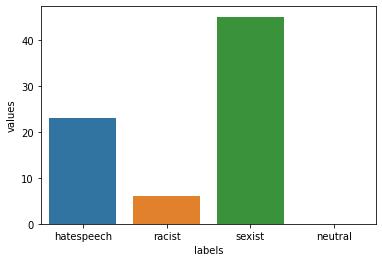

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import html
import re
from transformers import pipeline
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BartTokenizer, BartModel
from transformers import pipeline

print('INITIALIZING DATA PROCESSING + CLEANING')

try:
    user_csv = input('Please input the exact name of the CSV file you wish to analyze: ')
    tweet_column = input('Please input the name of the column containing the tweets: ')
    tweet_column_with_quotes = "'" + tweet_column + "'"

    dataframe = pd.read_csv(user_csv, delimiter=',',encoding='utf-8', header = 0)
    pd.set_option('display.max_colwidth', None)
    dataframe.rename(columns={tweet_column:'tweet'}) #renaming the tweet column to 'tweet'

except FileNotFoundError:
    print('There was an error finding the CSV you requested, please check the following:','\n', '1. The CSV file is in the correct directory', '\n', '2. You gave the correct name of the file, following the syntax: yourfilename.csv')


df_copy = dataframe.copy() #creating a copy of the dataframe
df_copy['tweet'] = df_copy['tweet'].str.lower() #making everything lower case
df_copy.drop_duplicates(subset='tweet', keep='first', inplace=True, ignore_index=False) #removing duplicates
df_copy[~df_copy.tweet.str.startswith('rt')] #removing retweets
df_copy['tweet'] = df_copy['tweet'].apply(lambda k: html.unescape(str(k))) #removing unnecessary characters

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed mentions
    text = re.sub(r'#', '', text) #Removed hashtags
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlink
    text = re.sub(r'\'[\s]+', '', text) #Remove apostrophe
    text = re.sub(r'\...+', '', text) #Remove dots
    text = re.sub(r'\!', '', text) #Remove exclamation  marks

    return text

df_copy['tweet'] = df_copy['tweet'].apply(clean_text)

df_copy.to_csv('Cleaned_Data.csv')

print('\n','DATA PROCESSING + CLEANING COMPLETE', '\n')
print('INITIALIZING DATA ANALYSIS')

print('The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results.', '\n', 'If you have not used it before, it may take a while to download as it is quite large.','\n')

model = input('If you wish to use Bart Large instead, type y.')

if model == 'y':
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartModel.from_pretrained('facebook/bart-large')
else:
    tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-1")
    model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-1", device = -1)

try:
    classifier = pipeline("zero-shot-classification", model = model, tokenizer = tokenizer, device = -1) #classifier = pipeline(task='zero-shot-classification', model=model, tokenizer=tokenizer, framework='pt')
except RuntimeError:
    print("A runtime error occurred, check if tensorflow and pytorch are correctly installed, need to be version >= 2")

df_original  = pd.read_csv(r'Cleaned_Data.csv')
rows = df_original['tweet'].count()

try:
    number_of_rows = int(input(f'Please specify the number of rows you wish to analyze, in your current dataset, there are {rows} rows of tweets, if you wish to look at them all, input any non-numerical character'))
    df_name = df_original.head(number_of_rows)
except ValueError:
    df_name = df_original

candidate_labels = []
candidate_results = []

def approval():
    candidate_labels = []
    labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')

    while labels != 'done':
        candidate_labels.append(labels)
        labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')
    
    print(f'{candidate_labels}')
    print('\n')
    approved = input('Are these labels correct? if so, type "y", if not, type any other character')

    if approved != "y":
        approval()
    else:
        print('APPRPOVED, INITALIZING TWEET ANALYSIS', '\n')
    return candidate_labels

candidate_labels = approval()
print(candidate_labels)

for x in range(len(candidate_labels)):
    candidate_results.append(0)

for sent in tqdm(df_name['tweet'].values):
        
    res = classifier(sent, candidate_labels, multi_label = True) #change multilabel to True for different results

    for i in range(len(candidate_labels)):
      if res['labels'][0] == candidate_labels[i] and res['scores'][0] > 0.5:
          candidate_results[i] = candidate_results[i] + 1

    if res['scores'][0] > 0.5: #the code below this can be removed if you do not wish to have all of the results printed (might be useful for when the program is actually implemented)
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print('\n')

data = {'labels': candidate_labels, 'values': candidate_results}
df_frequency = pd.DataFrame(data, columns=['labels', 'values'])
df_frequency.head()
sns.barplot(data = df_frequency, x = 'labels', y = 'values')


In [12]:
#THIS VERSION IS NOT FUNCITONING CORRECTLY

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import html
import re
from transformers import pipeline
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BartTokenizer, BartModel
from transformers import pipeline

print('INITIALIZING DATA PROCESSING + CLEANING')

try:
    user_csv = input('Please input the exact name of the CSV file you wish to analyze: ')
    tweet_column = input('Please input the name of the column containing the tweets: ')
    tweet_column_with_quotes = "'" + tweet_column + "'"

    dataframe = pd.read_csv(user_csv, delimiter=',',encoding='utf-8', header = 0)
    pd.set_option('display.max_colwidth', None)
    dataframe.rename(columns={tweet_column_with_quotes:'tweet'}) #renaming the tweet column to 'tweet'
    print(dataframe)
    
except FileNotFoundError:
    print('There was an error finding the CSV you requested, please check the following:','\n', '1. The CSV file is in the correct directory', '\n', '2. You gave the correct name of the file, following the syntax: yourfilename.csv')


df_copy = dataframe.copy() #creating a copy of the dataframe
df_copy[tweet_column] = df_copy[tweet_column].str.lower() #making everything lower case
print(df_copy[tweet_column])
df_copy.drop_duplicates(subset=tweet_column, keep='first', inplace=True, ignore_index=False) #removing duplicates
df_copy[~df_copy.tweet_column.str.startswith('rt')] #removing retweets
df_copy[tweet_column] = df_copy[tweet_column].apply(lambda k: html.unescape(str(k))) #removing unnecessary characters

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed mentions
    text = re.sub(r'#', '', text) #Removed hashtags
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlink
    text = re.sub(r'\'[\s]+', '', text) #Remove apostrophe
    text = re.sub(r'\...+', '', text) #Remove dots
    text = re.sub(r'\!', '', text) #Remove exclamation  marks

    return text

df_copy['tweet'] = df_copy['tweet'].apply(clean_text)

df_copy.to_csv('Cleaned_Data.csv')

print('\n','DATA PROCESSING + CLEANING COMPLETE', '\n')
print('INITIALIZING DATA ANALYSIS')

print('The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results.', '\n', 'If you have not used it before, it may take a while to download as it is quite large.','\n')

model = input('If you wish to use Bart Large instead, type y.')

if model == 'y':
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartModel.from_pretrained('facebook/bart-large')
else:
    tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-1")
    model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-1", device = -1)

try:
    classifier = pipeline("zero-shot-classification", model = model, tokenizer = tokenizer, device = -1) #classifier = pipeline(task='zero-shot-classification', model=model, tokenizer=tokenizer, framework='pt')
except RuntimeError:
    print("A runtime error occurred, check if tensorflow and pytorch are correctly installed, need to be version >= 2")

df_original  = pd.read_csv(r'Cleaned_Data.csv')
rows = df_original['tweet'].count()

try:
    number_of_rows = int(input(f'Please specify the number of rows you wish to analyze, in your current dataset, there are {rows} rows of tweets, if you wish to look at them all, input any non-numerical character'))
    df_name = df_original.head(number_of_rows)
except ValueError:
    df_name = df_original

candidate_labels = []
candidate_results = []

def approval():
    candidate_labels = []
    labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')

    while labels != 'done':
        candidate_labels.append(labels)
        labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')
    
    print(f'{candidate_labels}')
    print('\n')
    approved = input('Are these labels correct? if so, type "y", if not, type any other character')

    if approved != "y":
        approval()
    else:
        print('APPRPOVED, INITALIZING TWEET ANALYSIS', '\n')
    return candidate_labels

candidate_labels = approval()
print(candidate_labels)

for x in range(len(candidate_labels)):
    candidate_results.append(0)

for sent in tqdm(df_name['tweet'].values):
        
    res = classifier(sent, candidate_labels, multi_label = True) #change multilabel to True for different results

    for i in range(len(candidate_labels)):
      if res['labels'][0] == candidate_labels[i] and res['scores'][0] > 0.5:
          candidate_results[i] = candidate_results[i] + 1

    if res['scores'][0] > 0.5: #the code below this can be removed if you do not wish to have all of the results printed (might be useful for when the program is actually implemented)
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print('\n')

data = {'labels': candidate_labels, 'values': candidate_results}
df_frequency = pd.DataFrame(data, columns=['labels', 'values'])
df_frequency.head()
sns.barplot(data = df_frequency, x = 'labels', y = 'values')


INITIALIZING DATA PROCESSING + CLEANING
                     timestamp          location  \
0    2021-12-18 10:50:01+00:00               NaN   
1    2021-12-18 10:50:00+00:00          Kent, UK   
2    2021-12-18 10:48:18+00:00   Česká republika   
3    2021-12-18 10:48:12+00:00               NaN   
4    2021-12-18 10:48:00+00:00     London, Paris   
..                         ...               ...   
495  2021-12-18 08:12:48+00:00     United States   
496  2021-12-18 08:12:17+00:00   Los Angeles, CA   
497  2021-12-18 08:11:36+00:00      Here and Now   
498  2021-12-18 08:11:16+00:00   Bangalore India   
499  2021-12-18 08:11:00+00:00  Faaborg, Denmark   

                                                                                                                                                                                                                                                                                                                                               

AttributeError: 'DataFrame' object has no attribute 'tweet_column'